# Python for Engineering Analysis

By

**Olagoke Oladokun**  
**Bemgba Bevan Nyakuma**  
**Arshad Ahmad**

---

# Advance Modelling and Simulation (Kinetic Study: Model Fitting)

Install the following packages into your python environment.
1. numpy
2. xlrd
3. pandas
4. scipy
5. matplotlib


In [1]:
%pip install numpy xlrd pandas scipy matplotlib scikit-learn

## Kinetic Study: Model Fitting

#### Import modules

In [2]:
import numpy as np
# import numpy.polynomial.polynomial as npp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression

### Function Defined

In [3]:
def plot_show_save(fname):
    plt.savefig(fname, format="svg")
    plt.show()

In [4]:
# n order
# (1-(1-x)**(1-n))/(1-n) = kt

def nOrderModel(x,n=1.0):
    if n == 1.0:
        y=-np.log(1.0-x)
    else:
        y=(1-(1-x)**(1-n))/(1-n)  
    return y

In [5]:
def fixData(w):
#     w = v[['t','HM']]
    w = w.replace([np.inf, -np.inf], np.nan)
    w=w.dropna(how='any')
    
    return w

In [6]:
def fitData(x,y,n=1):
    coeff, stats = np.polynomial.polynomial.polyfit(x,y,n,full=True)

    # compute function
    yPred = np.polynomial.polynomial.polyval(x, coeff)

    # compute R-Squared
    SSR = stats[0][0]
    SST = np.linalg.norm(y-np.mean(y))**2
#     SST = np.sum((y-np.mean(y))**2)
    R2 = 1 - SSR/SST
    
    return coeff, stats, R2, yPred

In [7]:
def derivative(y,x):
    
    # using forward, center and backward difference
    m = len(y)
    
    dy = np.zeros(m)
    
    y2 = y[1]
    y1 = y[0]
    x2 = x[1]
    x1 = x[0]
    dy[0] = (y2-y1)/(x2-x1)

    for j in range(1,m-1):  
        y2 = y[j+1]
        y1 = y[j-1]
        x2 = x[j+1]
        x1 = x[j-1]
        dy[j] = (y2-y1)/(x2-x1)

    y2 = y[m-1]
    y1 = y[m-2]
    x2 = x[m-1]
    x1 = x[m-2]
    dy[m-1] = (y2-y1)/(x2-x1)
    
    return dy

In [8]:
def computeConversion(dfeDict):
    for (B,v) in dfeDict.items():

        # calculate conversion for each heating rate
        mo = v.iloc[0]['TGA']
        mf = v.iloc[-1]['TGA']
        v['X'] = (mo - v['TGA'])/(mo - mf)
        
        # compute derivative of conversion with temperature
        v['DXDT'] = derivative(v['X'].to_numpy(),v['T'].to_numpy())
        
        # compute derivative of conversion with time
        v['DXDt'] = derivative(v['X'].to_numpy(),v['t'].to_numpy())
        
        
    return dfeDict

### Load Data File

TGA file format
Temp (C) | t (min) | TGA (%) | DTG (%)

In [9]:
df = pd.read_excel('rawtga.xlsx')

### Display loaded data

In [10]:
df

,Temp_5,Time_5,TGA_5,DTG_5,Unnamed: 4,Temp_10,Time_10,TGA_10,DTG_10,Unnamed: 9,Temp_15,Time_15,TGA_15,DTG_15,Unnamed: 14,Temp_20,Time_20,TGA_20,DTG_20
0,C,min,%,-,NaN,C,min,%,-,NaN,C,min,%,-,NaN,C,min,%,-
1,5,5,5,5,NaN,10,10,10,10,NaN,15,15,15,15,NaN,20,20,20,20
2,4.8,4.8,4.8,4.8,NaN,9,9,9,9,NaN,8.3,8.3,8.3,8.3,NaN,7.7,7.7,7.7,7.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29.692,0,100,0.61361,NaN,30.945,0,100,-0.53178,NaN,27.457,0,100,-0.27409,NaN,27.043,0,100,-0.22254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,979.692,189.995,7.69563,-0.32573,NaN,980.945,95.1521,20.0334,-0.19303,NaN,977.457,63.2391,24.6772,-0.23183,NaN,977.043,47.4317,23.4953,-0.33824
195,984.692,190.993,7.3536,-0.34381,NaN,985.945,95.6514,19.9318,-0.20141,NaN,982.457,63.5715,24.5971,-0.23097,NaN,982.043,47.6798,23.3982,-0.3434
196,989.692,191.99,7.00465,-0.33146,NaN,990.945,96.1509,19.8339,-0.20271,NaN,987.457,63.9038,24.5256,-0.23149,NaN,987.043,47.928,23.3154,-0.33808
197,994.692,192.99,6.67997,-0.32714,NaN,995.945,96.6498,19.7313,-0.20892,NaN,992.457,64.2358,24.4476,-0.2453,NaN,992.043,48.1759,23.2388,-0.33378


In [11]:
# get number of Heating rates

In [12]:
(Rows, Cols) = df.shape

In [13]:
(Rows, Cols)

(199, 19)

In [14]:
no_of_samples = round(Cols/5)

In [15]:
no_of_samples

4

In [16]:
# initialize variables

In [17]:
heatRateList = []
massList = []
dfeList =[]
dfeDict= {}
dfMaxDict = {}
dfIsoConvDict= {}

In [18]:
# get each experiment data

In [19]:
heatRateList = []
massList = []
dfeDict= {}

a = 0
b = a+3

for i in range(no_of_samples):
    heatingRate = df.iloc[1, a]
    heatRateList.insert(i, heatingRate)
    mass = df.iloc[2, a]
    massList.insert(i, mass)
    
    dfe = df.iloc[4:,a:(b+1)]
    
    dfe.columns = ['T', 't', 'TGA', 'DTG',]
    # dfeList.append(dfe)
    
    dfeDict[heatRateList[i]] = dfe.dropna(how='all').astype(float)
    a = b+2
    b = a+3  
    

In [20]:
heatRateList

[5, 10, 15, 20]

In [21]:
massList

[4.8, 9, 8.3, 7.7]

In [22]:
dfeDict

{5:            T          t        TGA      DTG
 4     29.692    0.00000  100.00000  0.61361
 5     34.692    1.63523   99.63026 -0.50031
 6     39.692    2.66807   99.00546 -0.61951
 7     44.692    3.61761   98.41193 -0.63960
 8     49.692    4.55174   97.77192 -0.61778
 ..       ...        ...        ...      ...
 193  974.692  188.99578    7.99745 -0.32813
 194  979.692  189.99495    7.69563 -0.32573
 195  984.692  190.99338    7.35360 -0.34381
 196  989.692  191.98951    7.00465 -0.33146
 197  994.692  192.99033    6.67997 -0.32714
 
 [194 rows x 4 columns],
 10:            T         t        TGA      DTG
 4     30.945   0.00000  100.00000 -0.53178
 5     35.945   1.15249   99.41895 -0.59022
 6     40.945   1.78178   99.01448 -0.70916
 7     45.945   2.31515   98.61156 -0.82800
 8     50.945   2.80751   98.16741 -0.92455
 ..       ...       ...        ...      ...
 193  975.945  94.65279   20.12871 -0.18500
 194  980.945  95.15213   20.03345 -0.19303
 195  985.945  95.65136   19.9

In [23]:
# compute fractional converstion x
# x = (mo - mt)/(mo - mf)
# dx/dT

In [24]:
dfeDict = computeConversion(dfeDict)

In [25]:
dfeDict

{5:            T          t        TGA      DTG         X      DXDT      DXDt
 4     29.692    0.00000  100.00000  0.61361  0.000000  0.000792  0.002423
 5     34.692    1.63523   99.63026 -0.50031  0.003962  0.001066  0.003994
 6     39.692    2.66807   99.00546 -0.61951  0.010657  0.001306  0.006586
 7     44.692    3.61761   98.41193 -0.63960  0.017017  0.001322  0.007017
 8     49.692    4.55174   97.77192 -0.61778  0.023876  0.001266  0.006762
 ..       ...        ...        ...      ...       ...       ...       ...
 193  974.692  188.99578    7.99745 -0.32813  0.985882  0.000695  0.003472
 194  979.692  189.99495    7.69563 -0.32573  0.989116  0.000690  0.003454
 195  984.692  190.99338    7.35360 -0.34381  0.992782  0.000740  0.003712
 196  989.692  191.98951    7.00465 -0.33146  0.996521  0.000722  0.003615
 197  994.692  192.99033    6.67997 -0.32714  1.000000  0.000696  0.003476
 
 [194 rows x 7 columns],
 10:            T         t        TGA      DTG         X      DXDT   

In [26]:
B = heatRateList[i]
B

20

In [27]:
# get the last TGA experiment

v = dfeDict[heatRateList[i]]

In [28]:
v

,T,t,TGA,DTG,X,DXDT,DXDt
4,27.043,0.00000,100.00000,-0.22254,0.000000,-0.000136,-0.001089
5,32.043,0.62260,100.05211,-0.21649,-0.000678,0.000114,0.001165
6,37.043,0.97747,99.91248,-0.58787,0.001139,0.000476,0.007254
7,42.043,1.27870,99.68636,-0.91144,0.004081,0.000658,0.011456
8,47.043,1.55185,99.40681,-1.22792,0.007719,0.000817,0.015455
...,...,...,...,...,...,...,...
194,977.043,47.43168,23.49535,-0.33824,0.995521,0.000229,0.004611
195,982.043,47.67978,23.39816,-0.34340,0.996786,0.000234,0.004718
196,987.043,47.92801,23.31539,-0.33808,0.997863,0.000207,0.004180
197,992.043,48.17587,23.23881,-0.33378,0.998859,0.000214,0.004310


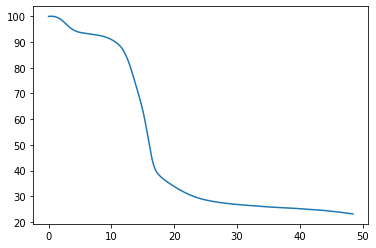

In [29]:
plt.plot(v['t'],v['TGA'])


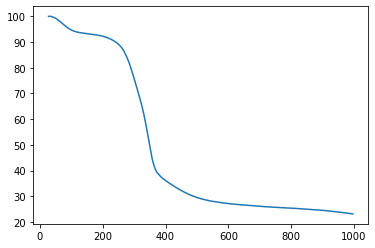

In [30]:
plt.plot(v['T'],v['TGA'])

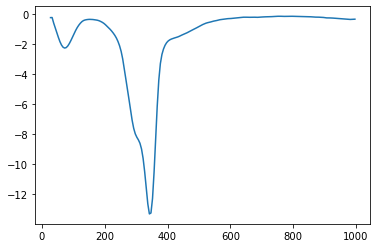

In [31]:
plt.plot(v['T'],v['DTG'])

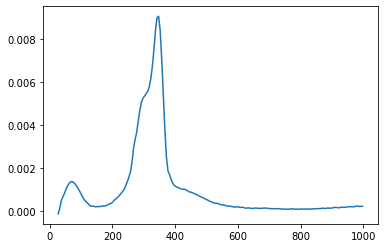

In [32]:
plt.plot(v['T'],v['DXDT'])

In [33]:
y = v['TGA'].to_numpy()
x=v['t'].to_numpy()
v['DTG2'] = -derivative(y,x)

In [34]:
v

,T,t,TGA,DTG,X,DXDT,DXDt,DTG2
4,27.043,0.00000,100.00000,-0.22254,0.000000,-0.000136,-0.001089,-0.083697
5,32.043,0.62260,100.05211,-0.21649,-0.000678,0.000114,0.001165,0.089537
6,37.043,0.97747,99.91248,-0.58787,0.001139,0.000476,0.007254,0.557461
7,42.043,1.27870,99.68636,-0.91144,0.004081,0.000658,0.011456,0.880375
8,47.043,1.55185,99.40681,-1.22792,0.007719,0.000817,0.015455,1.187684
...,...,...,...,...,...,...,...,...
194,977.043,47.43168,23.49535,-0.33824,0.995521,0.000229,0.004611,0.354325
195,982.043,47.67978,23.39816,-0.34340,0.996786,0.000234,0.004718,0.362581
196,987.043,47.92801,23.31539,-0.33808,0.997863,0.000207,0.004180,0.321212
197,992.043,48.17587,23.23881,-0.33378,0.998859,0.000214,0.004310,0.331196


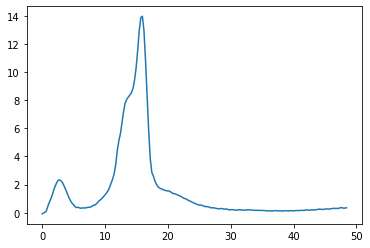

In [35]:
plt.plot(x,v['DTG2'])

### Get the center peak range

In [36]:
# get max point
k = v['DTG2'].idxmax()
iMax =v.loc[k]

# get the onset start point
z = v.loc[:k,['DTG2']].diff()
z = z[z['DTG2']<0]

zz = z.diff()

iz = zz[zz['DTG2']>=0].iloc[-1].name

k_start = zz.loc[iz:].iloc[1].name

# get the onset end point
z = v.loc[k:,['DTG2']].diff()
z = z[z['DTG2']>0]

zz = z.diff()

iz = zz[zz['DTG2']<=0].iloc[0].name

k_end = zz.loc[:iz].iloc[-2].name

#

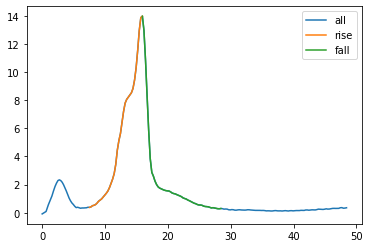

In [37]:
v_rise = v.loc[k_start:k,:]
v_fall = v.loc[k:k_end,:]

fig, ax = plt.subplots()

plt.plot(v['t'],v['DTG2'], label='all')
plt.plot(v_rise['t'],v_rise['DTG2'], label='rise')
plt.plot(v_fall['t'],v_fall['DTG2'], label='fall')

ax.legend()

plot_show_save('dtg2_peak.svg')

In [38]:
vv = v.loc[k_start:k_end]

In [39]:
vv

,T,t,TGA,DTG,X,DXDT,DXDt,DTG2
34,177.043,7.52201,92.82086,-0.40037,0.093419,0.000237,0.004959,0.381100
35,182.043,7.76157,92.73984,-0.43374,0.094473,0.000258,0.005383,0.413661
36,187.043,8.00163,92.62246,-0.48114,0.096001,0.000313,0.006506,0.499979
37,192.043,8.24287,92.49920,-0.53738,0.097605,0.000332,0.006865,0.527575
38,197.043,8.48594,92.36695,-0.60775,0.099325,0.000367,0.007546,0.579881
...,...,...,...,...,...,...,...,...
114,577.043,27.42624,27.52401,-0.33225,0.943098,0.000220,0.004395,0.337771
115,582.043,27.67633,27.44373,-0.31373,0.944143,0.000203,0.004052,0.311365
116,587.043,27.92636,27.36829,-0.29855,0.945124,0.000188,0.003754,0.288525
117,592.043,28.17653,27.29941,-0.29152,0.946021,0.000184,0.003673,0.282292


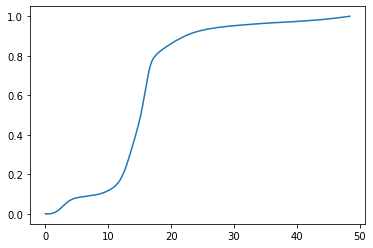

In [40]:
y = v['X']
t= v['t']
plt.plot(t,y)

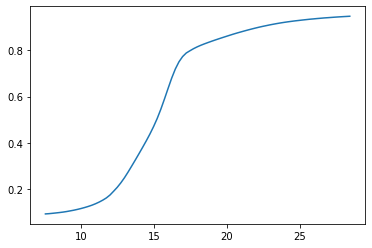

In [41]:
y = vv['X']
t= vv['t']
plt.plot(t,y)

In [42]:
# reaction rate

In [43]:
v

,T,t,TGA,DTG,X,DXDT,DXDt,DTG2
4,27.043,0.00000,100.00000,-0.22254,0.000000,-0.000136,-0.001089,-0.083697
5,32.043,0.62260,100.05211,-0.21649,-0.000678,0.000114,0.001165,0.089537
6,37.043,0.97747,99.91248,-0.58787,0.001139,0.000476,0.007254,0.557461
7,42.043,1.27870,99.68636,-0.91144,0.004081,0.000658,0.011456,0.880375
8,47.043,1.55185,99.40681,-1.22792,0.007719,0.000817,0.015455,1.187684
...,...,...,...,...,...,...,...,...
194,977.043,47.43168,23.49535,-0.33824,0.995521,0.000229,0.004611,0.354325
195,982.043,47.67978,23.39816,-0.34340,0.996786,0.000234,0.004718,0.362581
196,987.043,47.92801,23.31539,-0.33808,0.997863,0.000207,0.004180,0.321212
197,992.043,48.17587,23.23881,-0.33378,0.998859,0.000214,0.004310,0.331196


In [44]:
v1 = v.iloc[1:-1,:].copy()

In [45]:
v1

,T,t,TGA,DTG,X,DXDT,DXDt,DTG2
5,32.043,0.62260,100.05211,-0.21649,-0.000678,0.000114,0.001165,0.089537
6,37.043,0.97747,99.91248,-0.58787,0.001139,0.000476,0.007254,0.557461
7,42.043,1.27870,99.68636,-0.91144,0.004081,0.000658,0.011456,0.880375
8,47.043,1.55185,99.40681,-1.22792,0.007719,0.000817,0.015455,1.187684
9,52.043,1.80762,99.05817,-1.54365,0.012256,0.001012,0.020244,1.555707
...,...,...,...,...,...,...,...,...
193,972.043,47.18354,23.57399,-0.32477,0.994498,0.000201,0.004042,0.310592
194,977.043,47.43168,23.49535,-0.33824,0.995521,0.000229,0.004611,0.354325
195,982.043,47.67978,23.39816,-0.34340,0.996786,0.000234,0.004718,0.362581
196,987.043,47.92801,23.31539,-0.33808,0.997863,0.000207,0.004180,0.321212


,n,R2,k
1,1.0,0.949475,0.113916


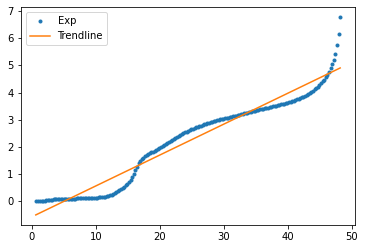

In [46]:
n=1
l='1'

x = v1['X'].to_numpy(float)
y = nOrderModel(x)

v1.loc[:,'HM'] = y

w = v1[['t','HM']]
w = fixData(w)

t= w['t'].to_numpy(float)
y = w['HM'].to_numpy(float)

coeff, stats, R2, yPred = fitData(t,y,1)

k = coeff[1]

rlt = np.zeros((1,3))
i=0

rlt[i,:] = [n, R2, k]

plt.plot(t,y,linestyle='',marker='.',label='Exp')
plt.plot(t,yPred,label='Trendline')
plt.legend()

pd.DataFrame(rlt, columns=['n','R2','k'],index=[l])


,n,R2,k
1,1.0,0.961763,0.16733


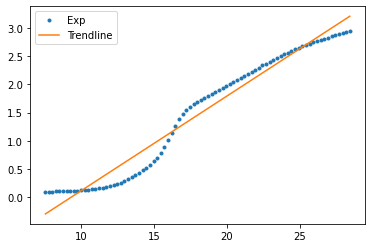

In [47]:
vv = v1.loc[k_start:k_end]

w = vv[['t','HM']]
w = fixData(w)

t= w['t'].to_numpy()
y = w['HM'].to_numpy()

coeff, stats, R2, yPred = fitData(t,y,1)

k = coeff[1]

rlt = np.zeros((1,3))
i=0

rlt[i,:] = [n, R2, k]

plt.plot(t,y,linestyle='',marker='.',label='Exp')
plt.plot(t,yPred,label='Trendline')
plt.legend()

pd.DataFrame(rlt, columns=['n','R2','k'],index=[l])


In [48]:
# shrinking core model
# n = 2/3
# 3(1-(1-x)^(1/3)) = kt

,n,R2,k
2/3,0.666667,0.908302,0.059553


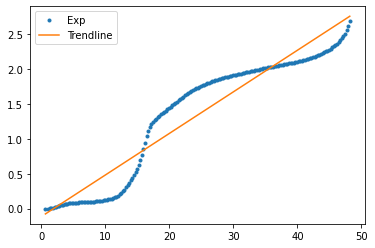

In [49]:
n=2.0/3.0
l='2/3'

x = v1['X']
y = nOrderModel(x,n)
v1['SCM']=y

w = v1[['t','SCM']]
w = fixData(w)

t= w['t']
y = w['SCM']

coeff, stats, R2, yPred = fitData(t,y,1)

k = coeff[1]

rlt = np.zeros((1,3))
i=0

rlt[i,:] = [n, R2, k]

plt.plot(t,y,linestyle='',marker='.',label='Exp')
plt.plot(t,yPred,label='Trendline')
plt.legend()

pd.DataFrame(rlt, columns=['n','R2','k'],index=[l])

,n,R2,k
2/3,0.666667,0.940623,0.10689


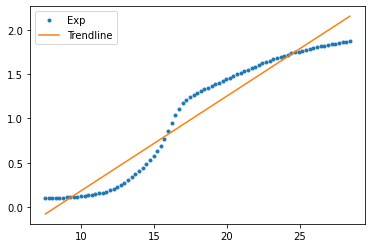

In [50]:
vv = v1.loc[k_start:k_end]

w = vv[['t','SCM']]
w = fixData(w)

t= w['t']
y = w['SCM']

coeff, stats, R2, yPred = fitData(t,y,1)

k = coeff[1]

rlt = np.zeros((1,3))
i=0

rlt[i,:] = [n, R2, k]

plt.plot(t,y,linestyle='',marker='.',label='Exp')
plt.plot(t,yPred,label='Trendline')
plt.legend()

pd.DataFrame(rlt, columns=['n','R2','k'],index=[l])

In [51]:
# volume reaction model
# n = 1/3

,n,R2,k
1/3,0.333333,0.836047,0.035983


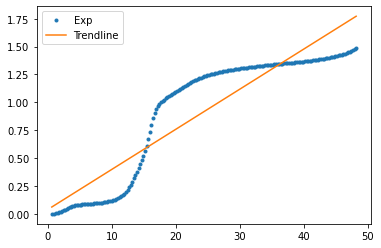

In [52]:
n=1.0/3.0
l='1/3'

x = v1['X']
y = nOrderModel(x,n)
v1['VRM'] = y

w = v1[['t','VRM']]
w = fixData(w)

t= w['t']
y = w['VRM']

coeff, stats, R2, yPred = fitData(t,y,1)

k = coeff[1]

rlt = np.zeros((1,3))
i=0

rlt[i,:] = [n, R2, k]

plt.plot(t,y,linestyle='',marker='.',label='Exp')
plt.plot(t,yPred,label='Trendline')
plt.legend()

pd.DataFrame(rlt, columns=['n','R2','k'],index=[l])

,n,R2,k
1/3,0.333333,0.910117,0.07224


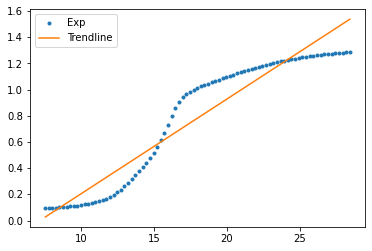

In [53]:
vv = v1.loc[k_start:k_end]

w = vv[['t','VRM']]
w = fixData(w)

t= w['t']
y = w['VRM']

coeff, stats, R2, yPred = fitData(t,y,1)

k = coeff[1]

rlt = np.zeros((1,3))
i=0

rlt[i,:] = [n, R2, k]

plt.plot(t,y,linestyle='',marker='.',label='Exp')
plt.plot(t,yPred,label='Trendline')
plt.legend()

pd.DataFrame(rlt, columns=['n','R2','k'],index=[l])

In [54]:
# specify order number, n
aOrder=np.linspace(0,5,41)
aOrder = np.array([0, 1/3, 2/3, 1/4, 2/4, 3/4, 1, 2, 3, 4, 5])
a_order_label = (['0', '1/3', '2/3', '1/4', '2/4', '3/4', '1', '2', '3', '4', '5'])
aOrder

array([0.        , 0.33333333, 0.66666667, 0.25      , 0.5       ,
       0.75      , 1.        , 2.        , 3.        , 4.        ,
       5.        ])

In [55]:
nrows=len(aOrder)
ncols=3

nrows, ncols

(11, 3)

,n,R2,k,XPlot,YPlot,YPredPlot
0,0.000000,0.778753,2.425052e-02,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006780843174620799, 0.001138858941935994,...","[0.10523384450498129, 0.11383962575533259, 0.1..."
1/3,0.333333,0.836047,3.598278e-02,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006780077074908241, 0.0011390752180384653...","[0.06127513910768032, 0.07404434716945382, 0.0..."
2/3,0.666667,0.908302,5.955295e-02,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006779311090592265, 0.0011392915489106812...","[-0.0756393700307198, -0.0545058162001317, -0...."
1/4,0.250000,0.819877,3.231220e-02,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006780268589017998, 0.001139021143878723,...","[0.07736589581016586, 0.08883252656173449, 0.0..."
2/4,0.500000,0.871463,4.556602e-02,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006779694068330677, 0.0011391833766274395...","[0.011652919542799057, 0.02782293153116797, 0...."
3/4,0.750000,0.925217,6.899213e-02,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006779119612545514, 0.0011393456401882496...","[-0.14195687574535246, -0.11747364023494788, -..."
1,1.000000,0.949475,1.139155e-01,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.000677854522165809, 0.001139507934568308, ...","[-0.5101817250159133, -0.46975652398061646, -0..."
2,2.000000,0.220486,2.658992e+00,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006776248306912258, 0.0011401574204095155...","[-33.79216434485881, -32.84856795071709, -32.0..."
3,3.000000,0.041162,4.234237e+02,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006773952429856567, 0.0011408073998810941...","[-6482.17342681888, -6331.913054102369, -6204...."
4,4.000000,0.023383,1.802414e+05,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006771657589963084, 0.0011414578734053975...","[-2808303.046461721, -2744340.7872310416, -269..."


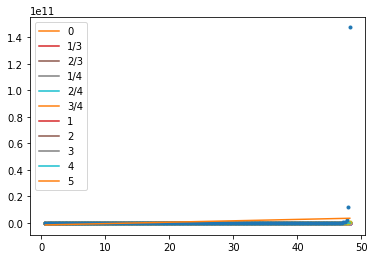

In [56]:
rlt = np.zeros((nrows,ncols))
xplot = []
yplot = []
ypred_plot = []

for i in range(nrows):
    n= aOrder[i]
    l= a_order_label[i]

    x = v1['X']
    y = nOrderModel(x,n)

    t = v1['t']

    w = pd.concat([t,y],axis=1)
    w.columns=['t','y']
    w = fixData(w)

    t= w['t']
    y = w['y']

    coeff, stats, R2, yPred = fitData(t,y,1)

    k = coeff[1]

    xplot.append(t.to_numpy())
    yplot.append(y.to_numpy())
    ypred_plot.append(yPred.to_numpy())
    
    rlt[i,:] = [n, R2, k]

    plt.plot(t,y,linestyle='',marker='.')
    plt.plot(t,yPred,label=l)
    plt.legend()

df_model = pd.DataFrame(rlt, columns=['n','R2','k'], index=a_order_label)
df_plot = pd.DataFrame([xplot,yplot,ypred_plot],columns=a_order_label,index=['XPlot','YPlot','YPredPlot']).T

df_model = pd.concat([df_model,df_plot],axis=1) 

df_model

In [57]:
best_model = df_model[df_model['R2'] > 0.8]
best_model

,n,R2,k,XPlot,YPlot,YPredPlot
1/3,0.333333,0.836047,0.035983,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006780077074908241, 0.0011390752180384653...","[0.06127513910768032, 0.07404434716945382, 0.0..."
2/3,0.666667,0.908302,0.059553,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006779311090592265, 0.0011392915489106812...","[-0.0756393700307198, -0.0545058162001317, -0...."
1/4,0.250000,0.819877,0.032312,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006780268589017998, 0.001139021143878723,...","[0.07736589581016586, 0.08883252656173449, 0.0..."
2/4,0.500000,0.871463,0.045566,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006779694068330677, 0.0011391833766274395...","[0.011652919542799057, 0.02782293153116797, 0...."
3/4,0.750000,0.925217,0.068992,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.0006779119612545514, 0.0011393456401882496...","[-0.14195687574535246, -0.11747364023494788, -..."
1,1.000000,0.949475,0.113916,"[0.6226, 0.97747, 1.2787, 1.55185, 1.80762, 2....","[-0.000677854522165809, 0.001139507934568308, ...","[-0.5101817250159133, -0.46975652398061646, -0..."


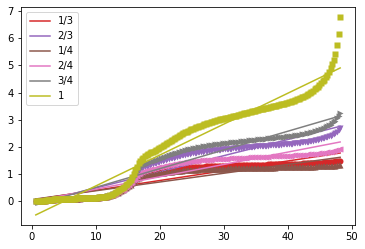

In [58]:
markers_cycler = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D','8', 'p','*','h','H','d','+','X',))

for i in best_model.index:
    x = best_model.loc[i,['XPlot']][0]
    y = best_model.loc[i,['YPlot']][0]
    yPred = best_model.loc[i,['YPredPlot']][0]
    
    color = next(ax._get_lines.prop_cycler)['color']
    
#     plt.plot(x,y,linestyle='',marker='.',color=color)
    plt.plot(x,y,linestyle='',markeredgecolor='none',marker=next(markers_cycler),color=color)
    plt.plot(x,yPred,label=i,color=color)
    plt.legend()

(0.7702949325853764,
 -14.429169337773812,
 -1697846.716000589,
 -1697846.716000589)

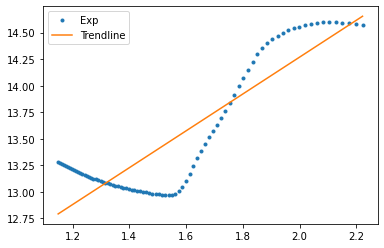

In [59]:
# Coat Redfern

R = 8.314

n = 1/3
v_peak = v1.loc[k_start:k_end]

T = v_peak['T'] + 273
x = v_peak['X']

X = 1/T
Y = np.log(nOrderModel(x,n)/(T**2))

w = pd.concat([X,Y],axis=1)
w.columns=['X','Y']
w = fixData(w)

X= w['X']*1000
Y = -w['Y']

coeff, stats, R2, YPred = fitData(X,Y,1)

plt.plot(X,Y,linestyle='',marker='.',label='Exp')
plt.plot(X,YPred,label='Trendline')
plt.legend()

coeff, stats, R2

B = B
s = coeff[1]
c = coeff[0]

E = -s*R

A1=-B*s*np.exp(c)
A2 = (1-2*T/s)
A = A1/A2

A = A1
R2, E, A, A1

In [60]:
# specify order number, n
aOrder=np.linspace(0,5,41)
aOrder = np.array([0, 1/3, 2/3, 1/4, 2/4, 3/4, 1, 2, 3, 4, 5])
a_order_label = (['0', '1/3', '2/3', '1/4', '2/4', '3/4', '1', '2', '3', '4', '5'])
aOrder

array([0.        , 0.33333333, 0.66666667, 0.25      , 0.5       ,
       0.75      , 1.        , 2.        , 3.        , 4.        ,
       5.        ])

In [61]:
nrows=len(aOrder)
ncols=6

nrows, ncols

(11, 6)

C:\sdks\Python38-32\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\sdks\Python38-32\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\sdks\Python38-32\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\sdks\Python38-32\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\sdks\Python38-32\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\sdks\Python38-32\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs

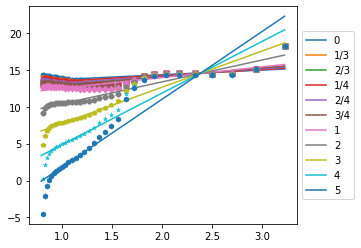

,n,R2,E,ko,ko1,ko2,XPlot,YPlot,YPredPlot
0,0.000000,0.360969,5.257002,1.257155e-08,0.000027,2484.106154,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.25115044103975, 17.006768228167584, 16.400...","[15.103881682657537, 15.071514388527323, 15.04..."
1/3,0.333333,0.507106,6.976964,3.733680e-08,0.000060,1871.970758,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.250960553108026, 17.006087013772387, 16.39...","[15.248509728550683, 15.205552655651129, 15.16..."
2/3,0.666667,0.658861,9.209033,1.264327e-07,0.000154,1418.488155,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.25077065315337, 17.005405644516994, 16.398...","[15.449601311383708, 15.392901418003694, 15.33..."
1/4,0.250000,0.469192,6.504646,2.814443e-08,0.000048,2007.826287,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.25100802621817, 17.006257331889323, 16.400...","[15.207763188504765, 15.167714167950475, 15.12..."
2/4,0.500000,0.583800,8.019870,6.740523e-08,0.000094,1628.669138,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.250865604633514, 17.00574634850221, 16.399...","[15.34086169557844, 15.291483461784772, 15.243..."
3/4,0.750000,0.694583,9.863744,1.758813e-07,0.000200,1324.401705,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.2507231762862, 17.00523527800628, 16.39808...","[15.510785687604553, 15.45005474933129, 15.391..."
1,1.000000,0.788615,12.087103,5.054519e-07,0.000469,1080.968868,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.25058074117573, 17.004724120401466, 16.397...","[15.723990998904409, 15.649570865501133, 15.57..."
2,2.000000,0.910755,24.643576,7.695172e-05,0.035066,530.699698,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.25001093310512, 17.00267861889352, 16.3932...","[16.993139413788413, 16.84140924012695, 16.694..."
3,3.000000,0.883109,40.728862,2.071014e-02,5.719865,321.502324,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.249441016828122, 17.00063172364496, 16.389...","[18.641264922039753, 18.390497857055067, 18.14..."
4,4.000000,0.859363,58.190932,6.235892e+00,1207.657890,225.325244,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.248870992344525, 16.998583434659263, 16.38...","[20.419854260524925, 20.06157346347765, 19.714..."


In [62]:
# Model Fitting

a_model = np.zeros((nrows,ncols))
xplot = []
yplot = []
ypred_plot = []

B = heatRateList[-1]

markers_cycler = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D','8', 'p','*','h','H','d','+','X',))
    
fig, ax = plt.subplots()
    
for i in range(nrows):
    R = 8.314

    n = aOrder[i]
    l = a_order_label[i]
    
    T = v1['T'] + 273
    x = v1['X']

    X = 1/T
    Y = np.log(nOrderModel(x,n)/(T**2))

    w = pd.concat([X,Y],axis=1)
    w.columns=['X','Y']
    w = fixData(w)

    X= w['X']*1000
    Y = -w['Y']
    
    # 
    N = len(X)
    
    h = int((N-1)/30)
    j = list(range(0,N,h))

#     plt.scatter(X.iloc[j],Y.iloc[j])
#     plt.plot(X.iloc[j],Y.iloc[j],'.')
    xScatter = X.iloc[j]
    yScatter = Y.iloc[j]

    coeff, stats, R2, yPred = fitData(X,Y,1)

    color = next(ax._get_lines.prop_cycler)['color']

    ax.plot(xScatter,yScatter,linestyle='', markeredgecolor='none', marker=next(markers_cycler), color=color)
#     ax.plot(xScatter,yScatter,linestyle='', markeredgecolor='none', marker='.', color=color)
    ax.plot(X,yPred,color=color,label=l)
        
#     plt.plot(X,YPred, label=n)
#     plt.legend()

#     coeff, stats, R2

    B = B
    s = -coeff[1]
    c = -coeff[0]

    E = -s*R

    k1=-B*s*np.exp(c)
    k2 = (1-2*T/s)
    
    ko = np.mean(k1/k2)
    
    ko1 = k1
    ko2 = np.mean(k2)

    a_model[i,:] = [n, R2, E, ko, ko1, ko2]
    xplot.append(X.to_numpy())
    yplot.append(Y.to_numpy())
    ypred_plot.append(yPred.to_numpy())
    
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

df_model = pd.DataFrame(a_model, columns=['n', 'R2', 'E', 'ko', 'ko1', 'ko2'], index=a_order_label)
df_plot = pd.DataFrame([xplot,yplot,ypred_plot],columns=a_order_label,index=['XPlot','YPlot','YPredPlot']).T

df_model = pd.concat([df_model,df_plot],axis=1) 

df_model

In [63]:
best_model = df_model[df_model['R2'] > 0.8]
best_model

,n,R2,E,ko,ko1,ko2,XPlot,YPlot,YPredPlot
2,2.0,0.910755,24.643576,0.000077,0.035066,530.699698,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.25001093310512, 17.00267861889352, 16.3932...","[16.993139413788413, 16.84140924012695, 16.694..."
3,3.0,0.883109,40.728862,0.020710,5.719865,321.502324,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.249441016828122, 17.00063172364496, 16.389...","[18.641264922039753, 18.390497857055067, 18.14..."
4,4.0,0.859363,58.190932,6.235892,1207.657890,225.325244,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.248870992344525, 16.998583434659263, 16.38...","[20.419854260524925, 20.06157346347765, 19.714..."
5,5.0,0.844979,76.268978,1904.467099,281934.204478,172.153400,"[3.2253590630976996, 3.1741698752233822, 3.124...","[18.24830085965454, 16.996533751942234, 16.381...","[22.25065380889864, 21.7810667191999, 21.32615..."


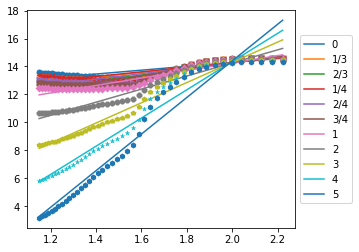

,n,R2,E,ko,ko1,ko2,XPlot,YPlot,YPredPlot
0,0.000000,0.689391,11.485093,2.953589e-07,2.725171e-04,956.603474,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.589347174438691, 14.600222478455468, 14.60...","[14.596170654198064, 14.562442850557568, 14.52..."
1/3,0.333333,0.770295,14.429169,9.659665e-07,7.096172e-04,761.625560,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.573223993396603, 14.583910678734739, 14.58...","[14.654185727833477, 14.611812176342521, 14.57..."
2/3,0.666667,0.834805,17.975235,3.571523e-06,2.106847e-03,611.573106,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.557011770347268, 14.567507712110055, 14.57...","[14.733432696280751, 14.680645559064835, 14.62..."
1/4,0.250000,0.751560,13.640064,7.106530e-07,5.522186e-04,805.629290,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.577263135578738, 14.587997174758575, 14.59...","[14.637829669080158, 14.597773450973442, 14.55..."
2/4,0.500000,0.804657,16.121874,1.827033e-06,1.201452e-03,681.764226,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.565129013237915, 14.575720592454326, 14.58...","[14.690945108096072, 14.64360066036881, 14.597..."
3/4,0.750000,0.848296,18.964658,5.058136e-06,2.828405e-03,579.718330,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.552944799889529, 14.563392723652477, 14.56...","[14.756928589310222, 14.701235854783913, 14.64..."
1,1.000000,0.882587,22.191798,1.514448e-05,7.239278e-03,495.560872,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.540710491016695, 14.551013563617964, 14.55...","[14.836755346601272, 14.771585600830608, 14.70..."
2,2.000000,0.945561,38.873034,2.541752e-03,6.947459e-01,283.334405,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.491272315335157, 14.500984026934653, 14.50...","[15.291556446022987, 15.177399596125813, 15.06..."
3,3.000000,0.951023,60.124576,9.639704e-01,1.707077e+02,183.540912,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.441033032595712, 14.450134272208363, 14.45...","[15.903226076998687, 15.72666069249701, 15.553..."
4,4.000000,0.945481,83.822005,5.302358e+02,6.750776e+04,131.934532,"[2.2220098968320805, 2.19759451304602, 2.17370...","[14.389993796642013, 14.398465508957296, 14.40...","[16.58886176052848, 16.342705105485507, 16.101..."


In [64]:
# Coat Redfern

v_peak = v1.loc[k_start:k_end]

a_model_cr = np.zeros((nrows,ncols))
xplot = []
yplot = []
ypred_plot = []

B = heatRateList[-1]

markers_cycler = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D','8', 'p','*','h','H','d','+','X',))
    
fig, ax = plt.subplots()
    
for i in range(nrows):
    R = 8.314

    n = aOrder[i]
    l = a_order_label[i]
    
    T = v_peak['T'] + 273
    x = v_peak['X']

    X = 1/T
    Y = np.log(nOrderModel(x,n)/(T**2))

    w = pd.concat([X,Y],axis=1)
    w.columns=['X','Y']
    w = fixData(w)

    X= w['X']*1000
    Y = -w['Y']
    
    # 
    N = len(X)
    h = int((N-1)/30)
    j = list(range(0,N,h))

#     plt.scatter(X.iloc[j],Y.iloc[j])
#     plt.plot(X.iloc[j],Y.iloc[j],'.')
    xScatter = X.iloc[j]
    yScatter = Y.iloc[j]

    coeff, stats, R2, yPred = fitData(X,Y,1)

    color = next(ax._get_lines.prop_cycler)['color']

    ax.plot(xScatter,yScatter,linestyle='', markeredgecolor='none', marker=next(markers_cycler), color=color)
    ax.plot(X,yPred,color=color,label=l)
        
#     plt.plot(X,YPred, label=n)
#     plt.legend()

    coeff, stats, R2

    B = B
    s = -coeff[1]
    c = -coeff[0]

    E = -s*R

    k1=-B*s*np.exp(c)
    k2 = (1-2*T/s)
    
    ko = np.mean(k1/k2)
    
    ko1 = k1
    ko2 = np.mean(k2)

    a_model_cr[i,:] = [n, R2, E, ko, ko1, ko2]
    xplot.append(X.to_numpy())
    yplot.append(Y.to_numpy())
    ypred_plot.append(yPred.to_numpy())
    
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

df_model_cr = pd.DataFrame(a_model_cr, columns=['n', 'R2', 'E', 'ko', 'ko1', 'ko2'], index=a_order_label)

df_plot = pd.DataFrame([xplot,yplot,ypred_plot],columns=a_order_label,index=['XPlot','YPlot','YPredPlot']).T

df_model_cr = pd.concat([df_model_cr,df_plot],axis=1) 

df_model_cr